# libs

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from nntool.nnops import NNops

nn_ob = NNops()

# net

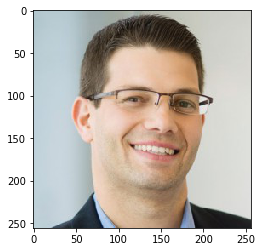

In [3]:
ip = plt.imread("./dummy.jpg")
ip_ = np.ndarray.astype(ip,np.float32)
ip_ = ip_.reshape(-1,ip_.shape[0],ip_.shape[1],ip_.shape[2])
plt.imshow(ip)

![Image of UNET](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

# contracting path

In [4]:
c1 = nn_ob.conv_layer(ip_, filter_size=4, num_input_channels=3,
                num_filters=64, strides=[1, 2, 2, 1], name="CONV_1")
p1 = nn_ob.pool_layer(c1[0], ksize=[1, 2, 2, 1], name="POOL_1")


c2 = nn_ob.conv_layer(p1, filter_size=4, num_input_channels=4,
                num_filters=128, strides=[1, 2, 2, 1], name="CONV_2")
p2 = nn_ob.pool_layer(c2[0], ksize=[1, 2, 2, 1], name="POOL_2")


c3 = nn_ob.conv_layer(p2, filter_size=4, num_input_channels=2,
                num_filters=256, strides=[1, 2, 2, 1], name="CONV_3")
p3 = nn_ob.pool_layer(c3[0], ksize=[1, 2, 2, 1], name="POOL_3")


c4 = nn_ob.conv_layer(p3, filter_size=4, num_input_channels=2,
                num_filters=512, strides=[1, 2, 2, 1], name="CONV_4")
p4 = nn_ob.pool_layer(c4[0], ksize=[1, 2, 2, 1], name="POOL_4")

CONV_1  [f x f x ip_ch, num_filters]=[4, 4, 3, 64]
CONV_1 op: (1, 128, 128, 64) 

POOL_1 ksize [1, 2, 2, 1]
POOL_1  op: (1, 128, 128, 64) 

CONV_2  [f x f x ip_ch, num_filters]=[4, 4, 4, 128]
CONV_2 op: (1, 64, 64, 128) 

POOL_2 ksize [1, 2, 2, 1]
POOL_2  op: (1, 64, 64, 128) 

CONV_3  [f x f x ip_ch, num_filters]=[4, 4, 2, 256]
CONV_3 op: (1, 32, 32, 256) 

POOL_3 ksize [1, 2, 2, 1]
POOL_3  op: (1, 32, 32, 256) 

CONV_4  [f x f x ip_ch, num_filters]=[4, 4, 2, 512]
CONV_4 op: (1, 16, 16, 512) 

POOL_4 ksize [1, 2, 2, 1]
POOL_4  op: (1, 16, 16, 512) 



# bottleneck

In [5]:
b1 = nn_ob.conv_layer(p4,filter_size=2,num_input_channels=2,num_filters=512,name="b1")
b1 = nn_ob.conv_layer(p4,filter_size=2,num_input_channels=2,num_filters=1024,name="b2")
b3 = nn_ob.conv_layer(p4,filter_size=2,num_input_channels=2,num_filters=512,name="b3")

b1  [f x f x ip_ch, num_filters]=[2, 2, 2, 512]
b1 op: (1, 16, 16, 512) 

b2  [f x f x ip_ch, num_filters]=[2, 2, 2, 1024]
b2 op: (1, 16, 16, 1024) 

b3  [f x f x ip_ch, num_filters]=[2, 2, 2, 512]
b3 op: (1, 16, 16, 512) 



# Expansive path

[copy and crop operation in UNET](https://stackoverflow.com/questions/53068877/u-net-copy-and-crop)

In [6]:
def convT_layer(input, filter_size,  num_input_channels, num_filters,
                strides, output_shape, name="TCONV_DEFAULT"):

    # conv_op,f,output_shape=ip.shape,strides=[1,2,2,1],padding="SAME"
    with tf.variable_scope(name) as scope:
        # Shape of the filter-weights for the transposed convolution
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        print(name, " [f x f x ip_channels, num_filters]", end="=")
        print(shape)

        # Create new weights (filters) with the given shape
        weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))

        # Create new biases, one for each filter
        biases = tf.Variable(tf.constant(0.05, shape=[num_filters]))

        # TensorFlow operation for transposed convolution
        layer = tf.nn.conv2d_transpose(input=input, filter=weights,
                                       strides=strides, output_shape=output_shape, padding='SAME', name=name)

        # Add the biases to the results of the transposed convolution.
        layer += biases

        print(name, "op:", layer.shape, "\n")

        return layer, weights

In [7]:
import tensorflow as tf
import numpy as np

x = tf.placeholder(dtype=tf.float32, shape=(None, 7, 7, 32))
dcout = tf.layers.conv2d_transpose(x, 64, 4, 3, padding="valid")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    xin = np.random.rand(1,7,7,32)
    out = sess.run(dcout, feed_dict={x:xin})
    print(out.shape)

W0916 15:02:42.087214 140403925239616 deprecation.py:323] From <ipython-input-7-1944ad569ed9>:5: conv2d_transpose (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
W0916 15:02:42.094202 140403925239616 deprecation.py:506] From /home/s/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


(1, 22, 22, 64)


# imp ref
[ouput shape, strides](https://datascience.stackexchange.com/questions/26451/how-to-calculate-the-output-shape-of-conv2d-transpose)

##### Padding==Same:
H = H1 * stride

##### Padding==Valid
H = (H1-1) * stride + HF

e.g., if `H1` = 7, Stride = 3, and Kernel size = 4, 

With padding=="same", output size = 21, 
with padding=="valid", output size = 22

In [8]:
b3[0]

<tf.Tensor 'b3/add:0' shape=(1, 16, 16, 512) dtype=float32>

In [9]:
tf.keras.layers.Conv2DTranspose(512, kernel_size=2, strides=(1,1), padding="SAME")(b3[0])

<tf.Tensor 'conv2d_transpose_1/BiasAdd:0' shape=(1, 16, 16, 512) dtype=float32>

# switch to keras

In [77]:
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import MaxPooling2D

from keras.layers import concatenate

In [ ]:
Conv2D(filters , kernel_size, strides, padding, activation)

In [18]:
ipk = tf.convert_to_tensor(ip_)
ipk

<tf.Tensor 'Const_1:0' shape=(1, 256, 256, 3) dtype=float32>

In [42]:
# compression
c1 = Convolution2D(filters=128, kernel_size=2, 
                   strides=(1,1), padding="SAME", activation='relu', name="conv1")(ipk)
m1 = MaxPooling2D()(c1, name="maxpool1")

c2 = Convolution2D(filters=256, kernel_size=2, 
                   strides=(1,1), padding="SAME", activation='relu', name="conv2")(m1)
m2 = MaxPooling2D()(c2, name="maxpool2")

c3 = Convolution2D(filters=512, kernel_size=2, 
                   strides=(1,1), padding="SAME", activation='relu', name="conv3")(m2)
m3 = MaxPooling2D()(c3, name="maxpool3")

In [70]:
for  i in [m1,m2,m3]:
    print(i.name, i.shape)

max_pooling2d_13/MaxPool:0 (1, 128, 128, 128)
max_pooling2d_14/MaxPool:0 (1, 64, 64, 256)
max_pooling2d_15/MaxPool:0 (1, 32, 32, 512)


In [82]:
# expansion
tc3 = UpSampling2D()(m3)
cc3 = concatenate([c3,tc3],axis=0)
ccv3 = Conv2DTranspose(filters=256, kernel_size=2, 
                   strides=(1,1), padding="SAME", activation='relu', name="tc-conv3")(cc3)

tc2 = UpSampling2D()(ccv3)
cc2 = concatenate([c2,tc2],axis=0)
ccv2 = Conv2DTranspose(filters=128, kernel_size=2, 
                   strides=(1,1), padding="SAME", activation='relu', name="tc-conv2")(cc2)

tc1 = UpSampling2D()(ccv2)
cc1 = concatenate([c1,tc1],axis=0)
ccv1 = Conv2DTranspose(filters=3, kernel_size=2, 
                   strides=(1,1), padding="SAME", activation='relu', name="tc-conv2")(cc1)

In [83]:
for i in [ccv3,ccv2,ccv1]:
    print(i.name, i.shape)

tc-conv3_8/Relu:0 (2, 64, 64, 256)
tc-conv2_17/Relu:0 (3, 128, 128, 128)
tc-conv2_18/Relu:0 (4, 256, 256, 3)
